In [331]:
import pandas as pd
import random
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import warnings
import gc
warnings.filterwarnings('ignore')

In [332]:
df = pd.read_csv('./Data/merged_sparse_preprocessed.csv').drop('Unnamed: 0', axis=1)

In [333]:
# preprocessing

for col in df.columns:
    _, uniques = pd.factorize(df[col])
    if list(uniques) == [0, 1]:
        df[col] = df[col].astype(bool)

df['Flag'] = df['Flag'].map({True: 1, False: 0})

print(df.dtypes)
display(df.head())

Avg_min_between_received_tnx    float64
Avg_min_between_sent_tnx        float64
Sent_tnx                        float64
Received_Tnx                    float64
Number_of_Created_Contracts     float64
                                 ...   
PC_63                           float64
PC_64                           float64
PC_65                           float64
Address                          object
Flag                              int64
Length: 176, dtype: object


,Avg_min_between_received_tnx,Avg_min_between_sent_tnx,Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Average_of_Unique_Received_From_Addresses,Average_of_Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,...,PC_58,PC_59,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,Address,Flag
0,-0.45,-0.07,7.55,1.42,-0.02,-0.17,-0.12,-0.06,-0.03,-0.07,...,-0.60,0.80,1.01,0.66,0.32,-1.52,0.81,-0.87,0x76e40d0a69fd81826b5eb7d18145626d46eafdef,0
1,-0.46,-0.07,-0.17,-0.20,-0.02,-0.17,-0.05,-0.05,0.15,0.16,...,0.03,-0.22,0.13,0.15,0.03,-0.16,0.11,-0.49,0x1c7ae6191fa64e91ba3812164e1c7ac6c4d87f28,0
2,0.34,-0.06,-0.19,-0.21,-0.02,-0.16,-0.11,-0.06,-0.04,-0.07,...,-0.07,0.10,-0.12,-0.10,-0.05,0.05,-0.09,0.21,0xf0767c8f2255d43447f663412b3bba422d2c3e33,1
3,-0.42,-0.07,-0.05,-0.06,-0.02,-0.17,0.33,-0.06,-0.04,-0.07,...,-0.02,-0.28,0.02,0.16,0.17,-0.12,-0.01,-1.16,0x8babc460731cc581bf7cc2d819069cb747077d55,1
4,-0.46,-0.07,-0.20,-0.22,-0.01,-0.18,-0.12,-0.06,-0.04,-0.07,...,0.56,-0.61,-0.13,-0.02,0.03,0.21,-0.51,0.95,0x7d4bf678252c1c85aa46e032bf70e76439ee1708,1


# Initial Model

In [334]:
import xgboost as xgb
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from pycm import ConfusionMatrix, Compare
from sklearn.model_selection import train_test_split, KFold

FOLD_NUMBER = 10
RANDOM_STATE = 23
METRIC_LIST = ["Accuracy", "F1", "Kappa", "Precision", "Recall"]

def model_output(model, features, target):

    kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
    cm_metric_list = []
    cm_worst = None
    cm_best = None
    cm_list = []

    # cross-validation training

    for idxTrain, idxTest in tqdm(kf.split(features)):
        X_train, X_test = features.iloc[idxTrain], features.iloc[idxTest]
        y_train, y_test = target.iloc[idxTrain], target.iloc[idxTest]

        clf = model
        h = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose=50)
        
        cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = clf.predict(X_test))
        cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                            , "Recall": cm.TPR[1]})
        cm.relabel({1: "Fraud", 0:"Non-Fraud"})
        cm_list.append(cm)
        if cm_worst is None:
            cm_worst = cm
        else:
            if cm.Overall_ACC < cm_worst.Overall_ACC:
                cm_worst = cm

        if cm_best is None:
            cm_best = cm
        else:
            if cm.Overall_ACC > cm_best.Overall_ACC:

                cm_best = cm
        del h, clf; x=gc.collect()
    
    # Model Evaluation for XGB
    
    print('#'*50)
    print("Model Name: XGBoost Classifier\n")
    print("10-Fold Metrics: \n")
    for metric in METRIC_LIST:
        temp = []
        for item in cm_metric_list:
            temp.append(item[metric])
        print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
    cm_worst.plot(title="XGB Worst", number_label=True)
    cm_best.plot(title="XGB Best", number_label=True)
    plt.show()
    

0it [00:00, ?it/s]

[0]	validation_0-auc:0.93767
[50]	validation_0-auc:0.98426
[100]	validation_0-auc:0.98715
[150]	validation_0-auc:0.98807
[200]	validation_0-auc:0.98942
[250]	validation_0-auc:0.99057
[300]	validation_0-auc:0.99104
[350]	validation_0-auc:0.99139
[400]	validation_0-auc:0.99160
[450]	validation_0-auc:0.99178
[500]	validation_0-auc:0.99196
[550]	validation_0-auc:0.99206
[600]	validation_0-auc:0.99220
[650]	validation_0-auc:0.99239
[700]	validation_0-auc:0.99243
[750]	validation_0-auc:0.99252
[800]	validation_0-auc:0.99258
[850]	validation_0-auc:0.99263
[900]	validation_0-auc:0.99264
[950]	validation_0-auc:0.99270
[999]	validation_0-auc:0.99273


1it [00:06,  6.53s/it]

[0]	validation_0-auc:0.93620
[50]	validation_0-auc:0.97970
[100]	validation_0-auc:0.98168
[150]	validation_0-auc:0.98299
[200]	validation_0-auc:0.98441
[250]	validation_0-auc:0.98508
[300]	validation_0-auc:0.98568
[350]	validation_0-auc:0.98584
[400]	validation_0-auc:0.98624
[450]	validation_0-auc:0.98644
[500]	validation_0-auc:0.98654
[550]	validation_0-auc:0.98661
[600]	validation_0-auc:0.98678
[650]	validation_0-auc:0.98688
[700]	validation_0-auc:0.98694
[750]	validation_0-auc:0.98705
[800]	validation_0-auc:0.98714
[850]	validation_0-auc:0.98718
[900]	validation_0-auc:0.98719
[950]	validation_0-auc:0.98723
[999]	validation_0-auc:0.98724


2it [00:13,  6.52s/it]

[0]	validation_0-auc:0.95321
[50]	validation_0-auc:0.98333
[100]	validation_0-auc:0.98478
[150]	validation_0-auc:0.98591
[200]	validation_0-auc:0.98700
[250]	validation_0-auc:0.98815
[300]	validation_0-auc:0.98879
[350]	validation_0-auc:0.98932
[400]	validation_0-auc:0.98995
[450]	validation_0-auc:0.99022
[500]	validation_0-auc:0.99051
[550]	validation_0-auc:0.99073
[600]	validation_0-auc:0.99084
[650]	validation_0-auc:0.99100
[700]	validation_0-auc:0.99105
[750]	validation_0-auc:0.99119
[800]	validation_0-auc:0.99128
[850]	validation_0-auc:0.99135
[900]	validation_0-auc:0.99142
[950]	validation_0-auc:0.99146
[999]	validation_0-auc:0.99152


3it [00:19,  6.50s/it]

[0]	validation_0-auc:0.93395
[50]	validation_0-auc:0.98456
[100]	validation_0-auc:0.98756
[150]	validation_0-auc:0.98929
[200]	validation_0-auc:0.99051
[250]	validation_0-auc:0.99134
[300]	validation_0-auc:0.99198
[350]	validation_0-auc:0.99223
[400]	validation_0-auc:0.99247
[450]	validation_0-auc:0.99263
[500]	validation_0-auc:0.99275
[550]	validation_0-auc:0.99283
[600]	validation_0-auc:0.99292
[650]	validation_0-auc:0.99292
[700]	validation_0-auc:0.99299
[750]	validation_0-auc:0.99305
[800]	validation_0-auc:0.99306
[850]	validation_0-auc:0.99308
[900]	validation_0-auc:0.99305
[950]	validation_0-auc:0.99304
[953]	validation_0-auc:0.99305


4it [00:25,  6.36s/it]

[0]	validation_0-auc:0.94891
[50]	validation_0-auc:0.98184
[100]	validation_0-auc:0.98360
[150]	validation_0-auc:0.98504
[200]	validation_0-auc:0.98609
[250]	validation_0-auc:0.98699
[300]	validation_0-auc:0.98769
[350]	validation_0-auc:0.98821
[400]	validation_0-auc:0.98858
[450]	validation_0-auc:0.98883
[500]	validation_0-auc:0.98921
[550]	validation_0-auc:0.98953
[600]	validation_0-auc:0.98972
[650]	validation_0-auc:0.98984
[700]	validation_0-auc:0.98995
[750]	validation_0-auc:0.99013
[800]	validation_0-auc:0.99026
[850]	validation_0-auc:0.99032
[900]	validation_0-auc:0.99041
[950]	validation_0-auc:0.99049
[999]	validation_0-auc:0.99058


5it [00:31,  6.33s/it]

[0]	validation_0-auc:0.94542
[50]	validation_0-auc:0.98650
[100]	validation_0-auc:0.98795
[150]	validation_0-auc:0.98905
[200]	validation_0-auc:0.98999
[250]	validation_0-auc:0.99084
[300]	validation_0-auc:0.99113
[350]	validation_0-auc:0.99146
[400]	validation_0-auc:0.99168
[450]	validation_0-auc:0.99191
[500]	validation_0-auc:0.99207
[550]	validation_0-auc:0.99209
[600]	validation_0-auc:0.99211
[650]	validation_0-auc:0.99211
[700]	validation_0-auc:0.99215
[750]	validation_0-auc:0.99218
[800]	validation_0-auc:0.99216
[843]	validation_0-auc:0.99215


6it [00:37,  6.15s/it]

[0]	validation_0-auc:0.95031
[50]	validation_0-auc:0.98637
[100]	validation_0-auc:0.98850
[150]	validation_0-auc:0.98947
[200]	validation_0-auc:0.99044
[250]	validation_0-auc:0.99110
[300]	validation_0-auc:0.99157
[350]	validation_0-auc:0.99180
[400]	validation_0-auc:0.99203
[450]	validation_0-auc:0.99207
[500]	validation_0-auc:0.99217
[550]	validation_0-auc:0.99233
[600]	validation_0-auc:0.99237
[650]	validation_0-auc:0.99243
[700]	validation_0-auc:0.99249
[750]	validation_0-auc:0.99250
[800]	validation_0-auc:0.99253
[850]	validation_0-auc:0.99253
[900]	validation_0-auc:0.99259
[950]	validation_0-auc:0.99254
[991]	validation_0-auc:0.99256


7it [00:44,  6.32s/it]

[0]	validation_0-auc:0.94182
[50]	validation_0-auc:0.98561
[100]	validation_0-auc:0.98800
[150]	validation_0-auc:0.98942
[200]	validation_0-auc:0.99072
[250]	validation_0-auc:0.99178
[300]	validation_0-auc:0.99235
[350]	validation_0-auc:0.99269
[400]	validation_0-auc:0.99315
[450]	validation_0-auc:0.99334
[500]	validation_0-auc:0.99353
[550]	validation_0-auc:0.99361
[600]	validation_0-auc:0.99374
[650]	validation_0-auc:0.99379
[700]	validation_0-auc:0.99397
[750]	validation_0-auc:0.99401
[800]	validation_0-auc:0.99404
[850]	validation_0-auc:0.99410
[900]	validation_0-auc:0.99412
[950]	validation_0-auc:0.99410
[978]	validation_0-auc:0.99412


8it [00:50,  6.40s/it]

[0]	validation_0-auc:0.94321
[50]	validation_0-auc:0.98241
[100]	validation_0-auc:0.98506
[150]	validation_0-auc:0.98613
[200]	validation_0-auc:0.98780
[250]	validation_0-auc:0.98882
[300]	validation_0-auc:0.98929
[350]	validation_0-auc:0.98978
[400]	validation_0-auc:0.99015
[450]	validation_0-auc:0.99040
[500]	validation_0-auc:0.99069
[550]	validation_0-auc:0.99080
[600]	validation_0-auc:0.99096
[650]	validation_0-auc:0.99101
[700]	validation_0-auc:0.99109
[750]	validation_0-auc:0.99108
[800]	validation_0-auc:0.99120
[850]	validation_0-auc:0.99128
[900]	validation_0-auc:0.99132
[950]	validation_0-auc:0.99135
[999]	validation_0-auc:0.99143


9it [00:57,  6.47s/it]

[0]	validation_0-auc:0.94136
[50]	validation_0-auc:0.98079
[100]	validation_0-auc:0.98374
[150]	validation_0-auc:0.98517
[200]	validation_0-auc:0.98664
[250]	validation_0-auc:0.98784
[300]	validation_0-auc:0.98844
[350]	validation_0-auc:0.98875
[400]	validation_0-auc:0.98909
[450]	validation_0-auc:0.98928
[500]	validation_0-auc:0.98943
[550]	validation_0-auc:0.98954
[600]	validation_0-auc:0.98971
[650]	validation_0-auc:0.98974
[700]	validation_0-auc:0.98979
[750]	validation_0-auc:0.98988
[800]	validation_0-auc:0.98998
[850]	validation_0-auc:0.99001
[900]	validation_0-auc:0.99003
[950]	validation_0-auc:0.99003
[999]	validation_0-auc:0.99007


10it [01:04,  6.44s/it]

##################################################
Model Name: XGBoost Classifier

10-Fold Metrics: 

Accuracy : 0.96

F1 : 0.96

Kappa : 0.91

Precision : 0.96

Recall : 0.96



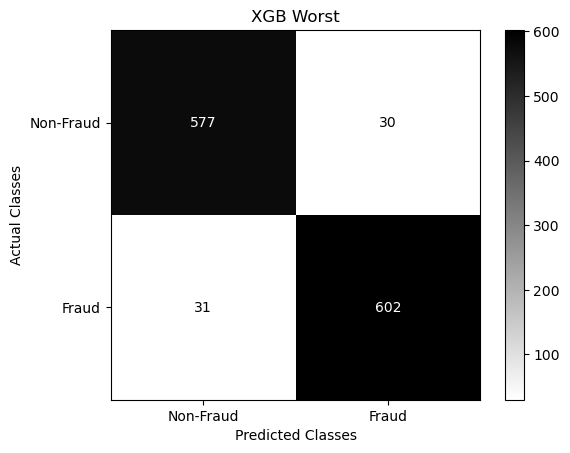

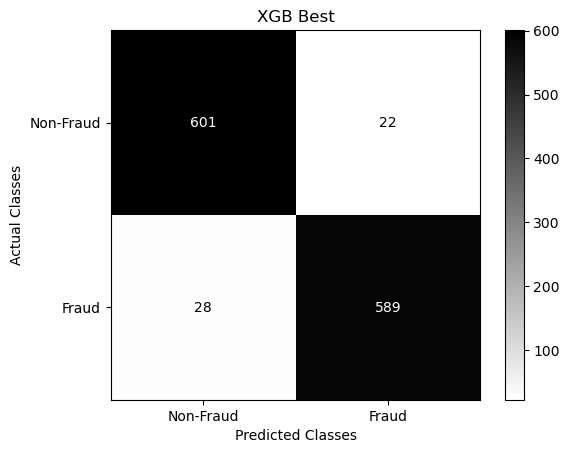

In [335]:
y = df["Flag"]
X = df.drop(['Flag', 'Address'], axis=1)

model1 = xgb.XGBClassifier(
        n_estimators=1000, #5000
        max_depth=12, #12
        learning_rate=0.02, #0.02
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        early_stopping_rounds=100,
        # USE CPU
        nthread=-1,
        tree_method='hist',
        random_state=42)

model_output(model=model1, features=X, target=y)

# Hypothesis Testing

In [336]:
# CHI-SQUARED TEST FOR IMPORTANCE OF CATEGORICAL FEATURES

df_dense = pd.read_csv('./Data/merged_dense_preprocessed.csv').drop('Unnamed: 0', axis=1)

for col in df_dense.columns:
    _, uniques = pd.factorize(df_dense[col])
    if list(uniques) == [0, 1]:
        df_dense[col] = df_dense[col].astype('bool')
    elif len(list(uniques)) <= 24:
        df_dense[col] = df_dense[col].astype('category')

df_dense['Flag'] = df_dense['Flag'].map({True: 1, False: 0})

# print('#'*50)
# print('Numerical Features:')
# print(df_dense.select_dtypes(include=['int64', 'float64']).columns)
print('#'*50)
print('Categorical Features:')
print(df_dense.select_dtypes(include=['category', 'object', 'bool']).columns)

##################################################
Categorical Features:
Index(['Address', 'most_frequent_month', 'num_month', 'most_frequent_day',
       'num_day', 'most_frequent_hour', 'num_hour', 'total_ether_balance_gap'],
      dtype='object')


In [337]:
from scipy.stats import chi2_contingency

X_cat = df_dense.select_dtypes(include=['category', 'bool', 'object']).drop(['Address'], axis=1)
y = df_dense['Flag']

contingency_tables = []
chi2_results = {}
for cat in X_cat.columns:
    cross = pd.crosstab(df_dense[cat], y)
    chi2, p, _, _ = chi2_contingency(cross)
    chi2_results[cat] = {'chi2': chi2, 'p_value': p}

chi2_results_p = {}
for k, v in chi2_results.items(): chi2_results_p[k] = v['p_value']

sorted(chi2_results_p.items(), key=lambda x: x[1])

[('most_frequent_month', 0.0),
 ('num_month', 0.0),
 ('num_day', 0.0),
 ('num_hour', 0.0),
 ('most_frequent_hour', 3.667952797966157e-263),
 ('most_frequent_day', 3.10027684197174e-141),
 ('total_ether_balance_gap', 4.5603014394791394e-129)]

In [338]:
# CORRELATION TEST TO REDUCE DIMENSIONS OF NUMERICAL FEATURES

def output_correlated_pairs(crrm, thresh):
    corr_pairs = []
    i = 1
    for f1 in crrm.columns:
        for indexer in range(i, len(crrm.columns)):
            f2 = crrm.index[indexer]
            fn = f1 + ' & ' + f2
            corr = crrm[f1].iloc[indexer]
            if (corr > thresh):
                print(fn, 'correlation = ', corr)
                corr_pairs.append([f1, f2])
        i += 1

    return corr_pairs

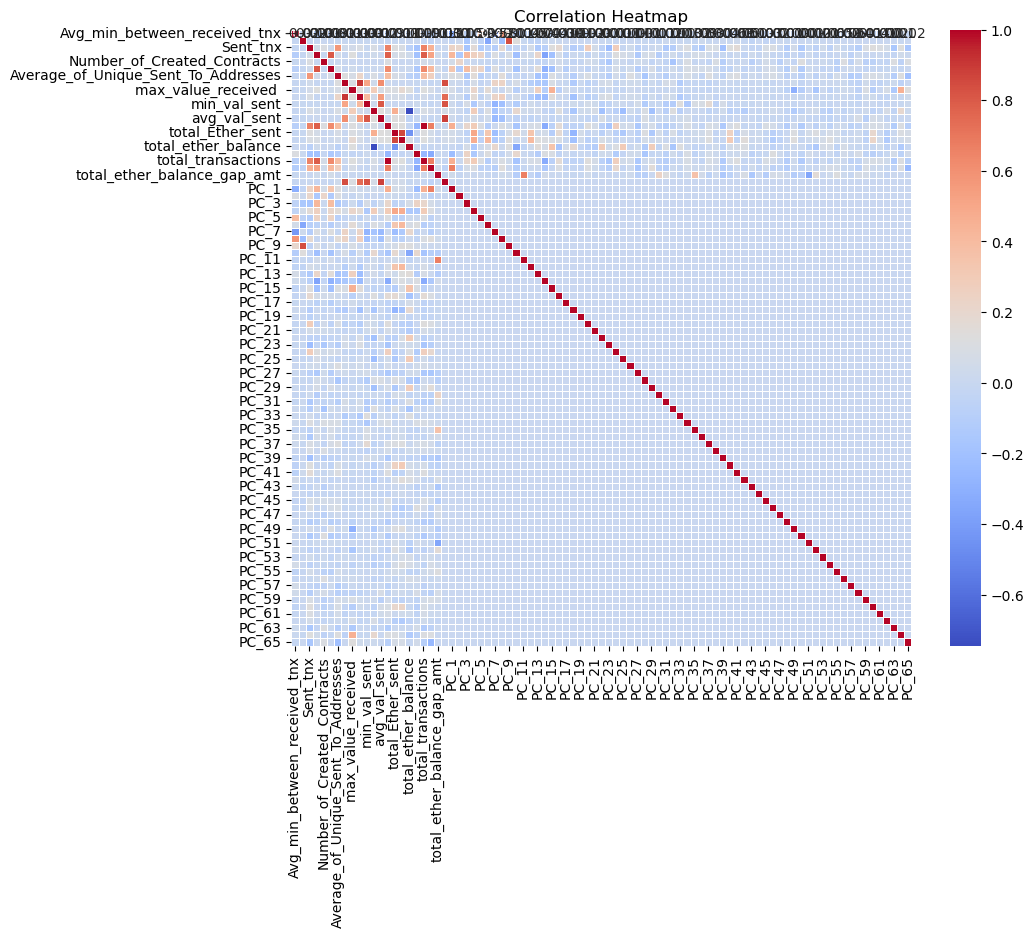

Avg_min_between_sent_tnx & PC_9 correlation =  0.8424815497085791
Received_Tnx & Average_of_Unique_Received_From_Addresses correlation =  0.8057733784659861
min_value_received & avg_val_received correlation =  0.9077985937769336
min_value_received & PC_0 correlation =  0.8378805197448407
min_val_sent & avg_val_sent correlation =  0.8025030059292257
min_val_sent & PC_0 correlation =  0.8176970351336088
avg_val_sent & PC_0 correlation =  0.87993595885165
total_transactions_including_tnx_to_create_contract & total_transactions correlation =  0.9988837515926442
total_Ether_sent & total_ether_received correlation =  0.8587122603034207


In [339]:
X_num = df_dense.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10, 8))
sns.heatmap(X_num.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

corr_pairs = output_correlated_pairs(X_num.corr(), 0.8)

# Feature Selection via Wrapper

In [340]:
# handle correlated features

from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score

X_train, _, y_train, _ = train_test_split(X, y, test_size=.25,random_state=42)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)

remove_corr = []

for pair in corr_pairs:

    score = 0
    worst_feature = pair[0]

    for col in pair:

        col_score = 0

        for idxT, idxV in kf.split(X_train):
            X_train_sub, X_val = X_train.iloc[idxT], X_train.iloc[idxV]
            y_train_sub, y_val = y_train.iloc[idxT], y_train.iloc[idxV]

            model = xgb.XGBClassifier(
            eval_metric='auc',
            early_stopping_rounds=100,
            nthread=-1,
            tree_method='hist',
            random_state=42)

            model.fit(X_train_sub[[col]], y_train_sub, eval_set=[(X_val[[col]], y_val)], verbose=0)

            pred = model.predict_proba(X_val[[col]])[:, 1]
            col_score += roc_auc_score(y_val, pred) / kf.get_n_splits()

            del model; x=gc.collect()
        
        if col_score > score: score = col_score
        else: worst_feature = col

    remove_corr.append(worst_feature)


In [341]:
selected_features = []
for index in range(len(corr_pairs)):
    for item in corr_pairs[index]:
        if item != remove_corr[index]:
            selected_features.append(item)

selected_features = list(set(selected_features))
selected_features

['avg_val_received',
 'PC_0',
 'total_transactions_including_tnx_to_create_contract',
 'PC_9',
 'Average_of_Unique_Received_From_Addresses',
 'total_ether_received',
 'avg_val_sent']

In [342]:
# initialize XGB classifier on each feature, and whichever feature's auc <= 0.5 then drop

validation_features = [c for c in X.columns if c not in [item for sublist in corr_pairs for item in sublist]]

for col in validation_features:
    score = 0
    for idxT, idxV in kf.split(X_train):
        X_train_sub, X_val = X_train.iloc[idxT], X_train.iloc[idxV]
        y_train_sub, y_val = y_train.iloc[idxT], y_train.iloc[idxV]

        model = xgb.XGBClassifier(
        eval_metric='auc',
        early_stopping_rounds=100,
        nthread=-1,
        tree_method='hist',
        random_state=42)

        model.fit(X_train_sub[[col]], y_train_sub, eval_set=[(X_val[[col]], y_val)], verbose=0)

        pred = model.predict_proba(X_val[[col]])[:, 1]
        score += roc_auc_score(y_val, pred) / kf.get_n_splits()

        del model; x=gc.collect()
        
    if score > 0.5:
        selected_features.append(col)

print('Number of features dropped: ', len(X.columns) - len(selected_features))

Number of features dropped:  9


# Modified Model

0it [00:00, ?it/s]

[0]	validation_0-auc:0.95094
[50]	validation_0-auc:0.98380
[100]	validation_0-auc:0.98594
[150]	validation_0-auc:0.98761
[200]	validation_0-auc:0.98879
[250]	validation_0-auc:0.98965
[300]	validation_0-auc:0.99012
[350]	validation_0-auc:0.99047
[400]	validation_0-auc:0.99065
[450]	validation_0-auc:0.99089
[500]	validation_0-auc:0.99108
[550]	validation_0-auc:0.99128
[600]	validation_0-auc:0.99148
[650]	validation_0-auc:0.99156
[700]	validation_0-auc:0.99163
[750]	validation_0-auc:0.99171
[800]	validation_0-auc:0.99171
[850]	validation_0-auc:0.99181
[900]	validation_0-auc:0.99184
[950]	validation_0-auc:0.99191
[999]	validation_0-auc:0.99198


1it [00:06,  6.57s/it]

[0]	validation_0-auc:0.92674
[50]	validation_0-auc:0.97807
[100]	validation_0-auc:0.98061
[150]	validation_0-auc:0.98236
[200]	validation_0-auc:0.98342
[250]	validation_0-auc:0.98396
[300]	validation_0-auc:0.98461
[350]	validation_0-auc:0.98521
[400]	validation_0-auc:0.98536
[450]	validation_0-auc:0.98564
[500]	validation_0-auc:0.98574
[550]	validation_0-auc:0.98593
[600]	validation_0-auc:0.98592
[650]	validation_0-auc:0.98599
[700]	validation_0-auc:0.98600
[750]	validation_0-auc:0.98607
[800]	validation_0-auc:0.98610
[850]	validation_0-auc:0.98618
[900]	validation_0-auc:0.98624
[950]	validation_0-auc:0.98631
[999]	validation_0-auc:0.98634


2it [00:13,  6.52s/it]

[0]	validation_0-auc:0.94981
[50]	validation_0-auc:0.98288
[100]	validation_0-auc:0.98414
[150]	validation_0-auc:0.98566
[200]	validation_0-auc:0.98692
[250]	validation_0-auc:0.98769
[300]	validation_0-auc:0.98846
[350]	validation_0-auc:0.98903
[400]	validation_0-auc:0.98938
[450]	validation_0-auc:0.98961
[500]	validation_0-auc:0.98991
[550]	validation_0-auc:0.99019
[600]	validation_0-auc:0.99027
[650]	validation_0-auc:0.99032
[700]	validation_0-auc:0.99033
[727]	validation_0-auc:0.99034


3it [00:18,  5.91s/it]

[0]	validation_0-auc:0.94396
[50]	validation_0-auc:0.98527
[100]	validation_0-auc:0.98764
[150]	validation_0-auc:0.98960
[200]	validation_0-auc:0.99056
[250]	validation_0-auc:0.99129
[300]	validation_0-auc:0.99174
[350]	validation_0-auc:0.99209
[400]	validation_0-auc:0.99226
[450]	validation_0-auc:0.99240
[500]	validation_0-auc:0.99250
[550]	validation_0-auc:0.99256
[600]	validation_0-auc:0.99269
[650]	validation_0-auc:0.99266
[700]	validation_0-auc:0.99270
[750]	validation_0-auc:0.99274
[800]	validation_0-auc:0.99276
[850]	validation_0-auc:0.99275
[862]	validation_0-auc:0.99277


4it [00:24,  5.94s/it]

[0]	validation_0-auc:0.94098
[50]	validation_0-auc:0.98149
[100]	validation_0-auc:0.98316
[150]	validation_0-auc:0.98458
[200]	validation_0-auc:0.98575
[250]	validation_0-auc:0.98660
[300]	validation_0-auc:0.98736
[350]	validation_0-auc:0.98788
[400]	validation_0-auc:0.98818
[450]	validation_0-auc:0.98837
[500]	validation_0-auc:0.98870
[550]	validation_0-auc:0.98888
[600]	validation_0-auc:0.98909
[650]	validation_0-auc:0.98920
[700]	validation_0-auc:0.98931
[750]	validation_0-auc:0.98943
[800]	validation_0-auc:0.98959
[850]	validation_0-auc:0.98962
[900]	validation_0-auc:0.98972
[950]	validation_0-auc:0.98978
[999]	validation_0-auc:0.98983


5it [00:30,  6.14s/it]

[0]	validation_0-auc:0.94862
[50]	validation_0-auc:0.98506
[100]	validation_0-auc:0.98682
[150]	validation_0-auc:0.98841
[200]	validation_0-auc:0.98967
[250]	validation_0-auc:0.99053
[300]	validation_0-auc:0.99106
[350]	validation_0-auc:0.99131
[400]	validation_0-auc:0.99157
[450]	validation_0-auc:0.99170
[500]	validation_0-auc:0.99178
[550]	validation_0-auc:0.99188
[600]	validation_0-auc:0.99188
[650]	validation_0-auc:0.99194
[700]	validation_0-auc:0.99195
[750]	validation_0-auc:0.99198
[800]	validation_0-auc:0.99193
[842]	validation_0-auc:0.99196


6it [00:36,  6.05s/it]

[0]	validation_0-auc:0.94703
[50]	validation_0-auc:0.98700
[100]	validation_0-auc:0.98810
[150]	validation_0-auc:0.98923
[200]	validation_0-auc:0.99016
[250]	validation_0-auc:0.99071
[300]	validation_0-auc:0.99126
[350]	validation_0-auc:0.99151
[400]	validation_0-auc:0.99169
[450]	validation_0-auc:0.99187
[500]	validation_0-auc:0.99198
[550]	validation_0-auc:0.99210
[600]	validation_0-auc:0.99222
[650]	validation_0-auc:0.99221
[700]	validation_0-auc:0.99225
[750]	validation_0-auc:0.99227
[800]	validation_0-auc:0.99233
[850]	validation_0-auc:0.99235
[900]	validation_0-auc:0.99240
[950]	validation_0-auc:0.99235
[999]	validation_0-auc:0.99244


7it [00:42,  6.15s/it]

[0]	validation_0-auc:0.94789
[50]	validation_0-auc:0.98464
[100]	validation_0-auc:0.98695
[150]	validation_0-auc:0.98896
[200]	validation_0-auc:0.99019
[250]	validation_0-auc:0.99087
[300]	validation_0-auc:0.99126
[350]	validation_0-auc:0.99169
[400]	validation_0-auc:0.99206
[450]	validation_0-auc:0.99232
[500]	validation_0-auc:0.99254
[550]	validation_0-auc:0.99255
[600]	validation_0-auc:0.99274
[650]	validation_0-auc:0.99278
[700]	validation_0-auc:0.99289
[750]	validation_0-auc:0.99301
[800]	validation_0-auc:0.99309
[850]	validation_0-auc:0.99313
[900]	validation_0-auc:0.99320
[950]	validation_0-auc:0.99320
[999]	validation_0-auc:0.99330


8it [00:49,  6.21s/it]

[0]	validation_0-auc:0.94103
[50]	validation_0-auc:0.98281
[100]	validation_0-auc:0.98411
[150]	validation_0-auc:0.98598
[200]	validation_0-auc:0.98725
[250]	validation_0-auc:0.98828
[300]	validation_0-auc:0.98907
[350]	validation_0-auc:0.98962
[400]	validation_0-auc:0.99005
[450]	validation_0-auc:0.99020
[500]	validation_0-auc:0.99044
[550]	validation_0-auc:0.99051
[600]	validation_0-auc:0.99067
[650]	validation_0-auc:0.99075
[700]	validation_0-auc:0.99086
[750]	validation_0-auc:0.99086
[800]	validation_0-auc:0.99085
[850]	validation_0-auc:0.99087
[881]	validation_0-auc:0.99088


9it [00:55,  6.16s/it]

[0]	validation_0-auc:0.94294
[50]	validation_0-auc:0.98171
[100]	validation_0-auc:0.98332
[150]	validation_0-auc:0.98494
[200]	validation_0-auc:0.98582
[250]	validation_0-auc:0.98682
[300]	validation_0-auc:0.98740
[350]	validation_0-auc:0.98779
[400]	validation_0-auc:0.98799
[450]	validation_0-auc:0.98825
[500]	validation_0-auc:0.98845
[550]	validation_0-auc:0.98857
[600]	validation_0-auc:0.98872
[650]	validation_0-auc:0.98874
[700]	validation_0-auc:0.98879
[750]	validation_0-auc:0.98882
[800]	validation_0-auc:0.98888
[850]	validation_0-auc:0.98891
[900]	validation_0-auc:0.98897
[950]	validation_0-auc:0.98902
[999]	validation_0-auc:0.98902


10it [01:01,  6.19s/it]

##################################################
Model Name: XGBoost Classifier

10-Fold Metrics: 

Accuracy : 0.95

F1 : 0.95

Kappa : 0.91

Precision : 0.95

Recall : 0.95



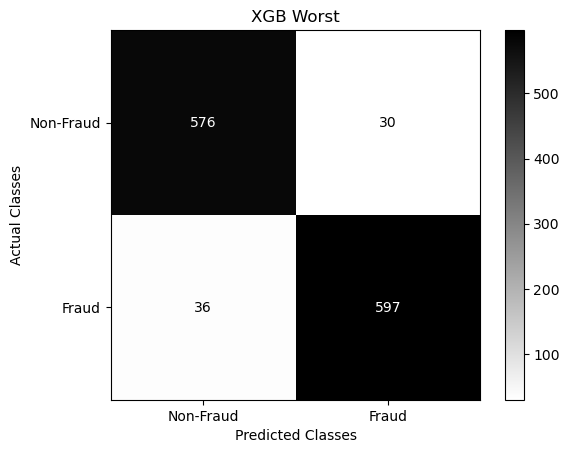

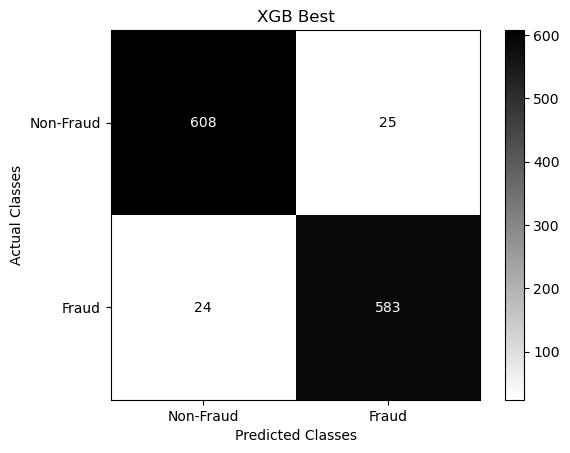

In [343]:
y = df["Flag"]
X = df[selected_features]

model2 = xgb.XGBClassifier(
        n_estimators=1000, #5000
        max_depth=12, #12
        learning_rate=0.02, #0.02
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        early_stopping_rounds=100,
        # USE CPU
        nthread=-1,
        tree_method='hist',
        random_state=42)

model_output(model=model2, features=X, target=y)